# 📈 Competitive Trends EDA

### 🎯 Research Question:
**What statistical and gameplay-related factors—such as typing, base stats, and abilities—are most strongly associated with high usage rates in competitive Pokémon formats, and what common trends can be identified among top-used Pokémon?**

This notebook investigates patterns in competitive usage data across Smogon and VGC formats by analyzing Pokémon attributes including:
- Base stats (HP, Attack, Speed, etc.)
- Typing (primary & secondary)
- Abilities (primary/special/event)

The goal is to identify **statistical correlations**, **cluster patterns**, and potential **predictors of meta relevance**.


In [32]:
# 📦 Import libraries
import os
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from collections import Counter

# 📄 Load environment variables
load_dotenv()

DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

# 🧠 Connect to the database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# ✅ Test connection
print("Database connection established!")


Database connection established!


In [33]:
df = pd.read_sql("SELECT * FROM pokemon_competitive_factors_view", conn)
df.head()


/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/694259048.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM pokemon_competitive_factors_view", conn)


,pokemon_id,true_pokemon_id,pokemon_name,alternate_form_name,sprite_path,label,health_stat,attack_stat,defense_stat,special_attack_stat,...,smogon_vgc_usage_2024,worlds_vgc_usage_2022,worlds_vgc_usage_2023,worlds_vgc_usage_2024,primary_type,secondary_type,primary_ability,secondary_ability,hidden_ability,event_ability
0,49,33,Nidoran (Female),None,None,Nidoran (Female),55,47,52,40,...,NaN,NaN,NaN,NaN,Poison,None,Poison Point,Rivalry,Hustle,None
1,52,48,Nidoran (Male),None,None,Nidoran (Male),46,57,40,40,...,NaN,NaN,NaN,NaN,Poison,None,Poison Point,Rivalry,Hustle,None
2,532,514,Deoxys,None,None,Deoxys,50,150,50,150,...,NaN,NaN,NaN,NaN,Psychic,None,Pressure,None,None,None
3,533,1391,Deoxys,Attack,None,Deoxys (Attack),50,180,20,180,...,NaN,NaN,NaN,NaN,Psychic,None,Pressure,None,None,None
4,534,1392,Deoxys,Defense,None,Deoxys (Defense),50,70,160,70,...,NaN,NaN,NaN,NaN,Psychic,None,Pressure,None,None,None


## ✅ Goal

We want to analyze the **top 30 Pokémon** (per format) from the `competitive_pokemon_view` for **Smogon 2022** and **Worlds 2022**, and investigate:

- 📊 Stat trends (individual and total)  
- 🔮 Common types  
- 🧠 Common abilities  


In [34]:
smogon_2022 = pd.read_sql("""
    SELECT *
    FROM pokemon_competitive_factors_view
    WHERE smogon_vgc_usage_2022 IS NOT NULL
    ORDER BY smogon_vgc_usage_2022 DESC
    LIMIT 30;
""", conn)

worlds_2022 = pd.read_sql("""
    SELECT *
    FROM pokemon_competitive_factors_view
    WHERE worlds_vgc_usage_2022 IS NOT NULL
    ORDER BY worlds_vgc_usage_2022 DESC
    LIMIT 30;
""", conn)


/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/3495759002.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smogon_2022 = pd.read_sql("""
/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/3495759002.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  worlds_2022 = pd.read_sql("""


## Display and compare top 30 pokemon across both formats

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/263013943.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=comparison_df, x="Usage", y="pokemon_name", hue="Format", palette="Set2", ci=None)
/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/263013943.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/rohanhangal/PersonalProjects/data_engineering/pokemon_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


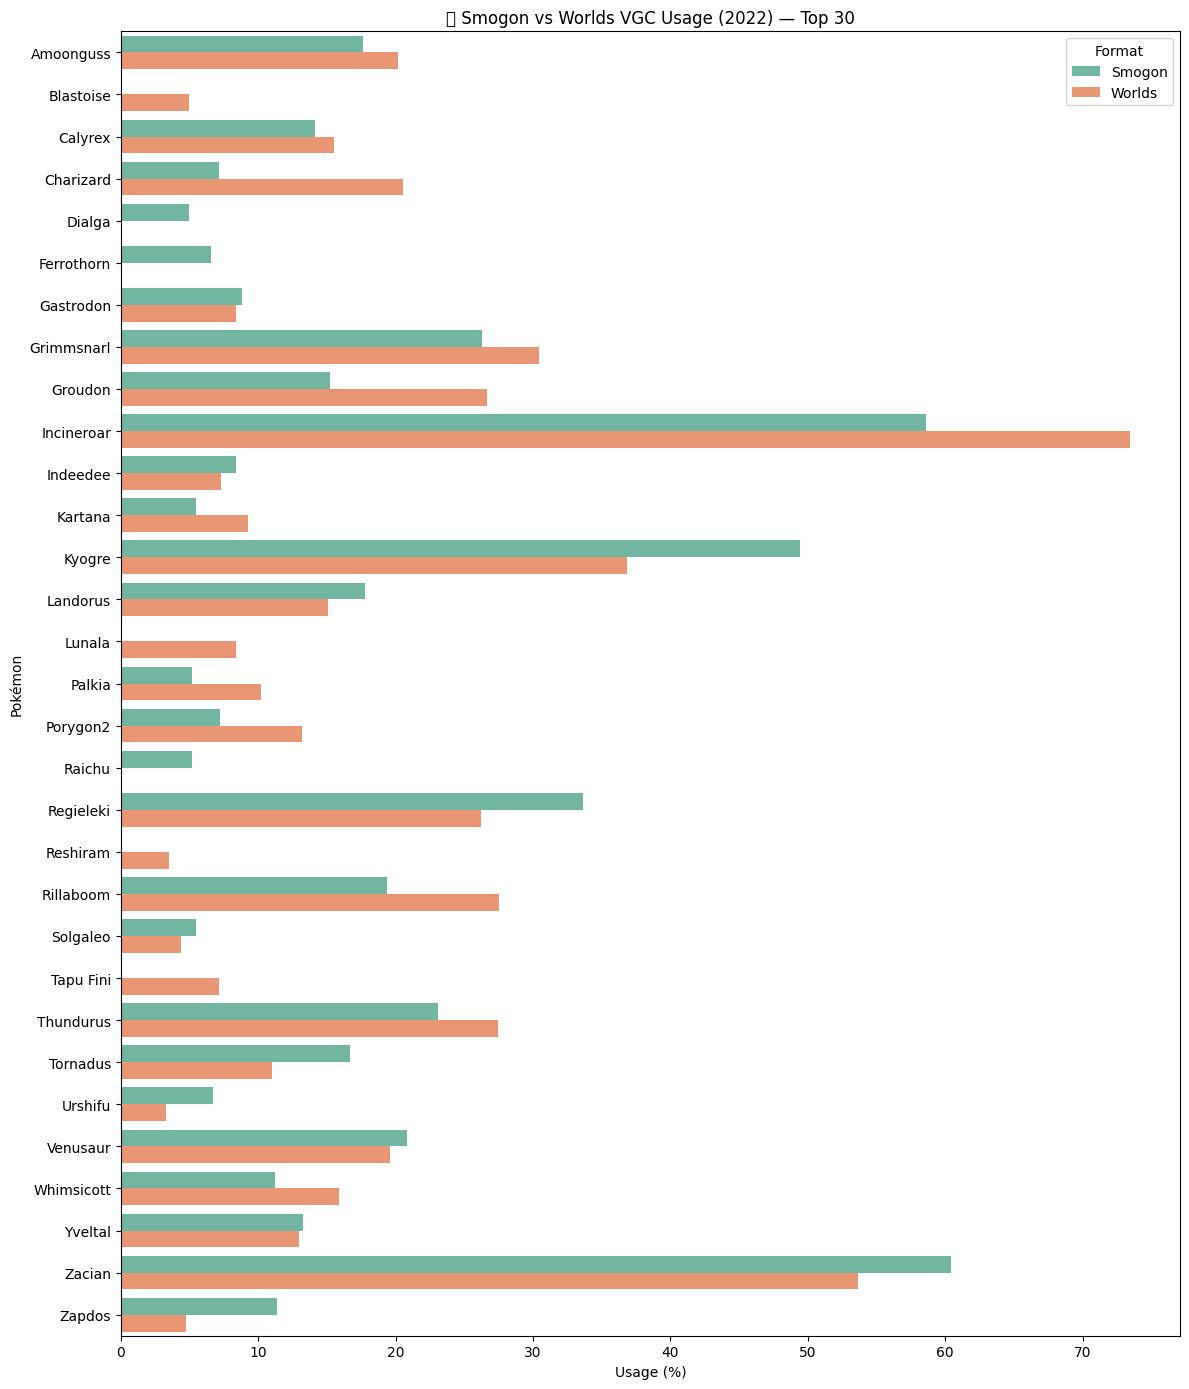

In [35]:
merged_usage = pd.merge(
    smogon_2022[["pokemon_name", "smogon_vgc_usage_2022"]],
    worlds_2022[["pokemon_name", "worlds_vgc_usage_2022"]],
    on="pokemon_name",
    how="outer"
).fillna(0)

# Then use "pokemon_name" instead of "label" for plotting:
comparison_df = merged_usage.melt(
    id_vars="pokemon_name",
    value_vars=["smogon_vgc_usage_2022", "worlds_vgc_usage_2022"],
    var_name="Format", value_name="Usage"
)

comparison_df["Format"] = comparison_df["Format"].replace({
    "smogon_vgc_usage_2022": "Smogon",
    "worlds_vgc_usage_2022": "Worlds"
})
comparison_df["Usage"] = comparison_df["Usage"] 

plt.figure(figsize=(12, 14))
sns.barplot(data=comparison_df, x="Usage", y="pokemon_name", hue="Format", palette="Set2", ci=None)
plt.title("📊 Smogon vs Worlds VGC Usage (2022) — Top 30")
plt.xlabel("Usage (%)")
plt.ylabel("Pokémon")
plt.legend(title="Format")
plt.tight_layout()
plt.show()




## Compare base stat distributions across both formats 

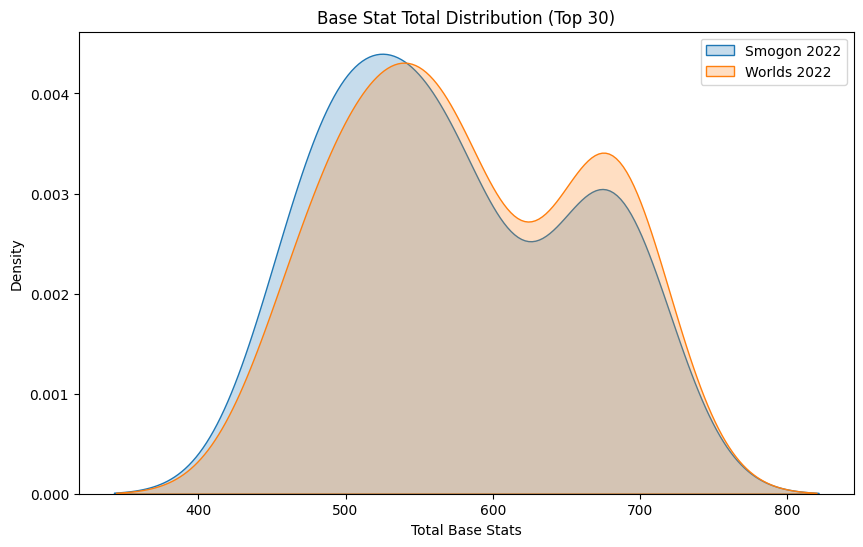

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(smogon_2022["base_stat_total"], label="Smogon 2022", fill=True)
sns.kdeplot(worlds_2022["base_stat_total"], label="Worlds 2022", fill=True)
plt.title("Base Stat Total Distribution (Top 30)")
plt.xlabel("Total Base Stats")
plt.legend()
plt.show()

## Compare individual stat distributions across both formats

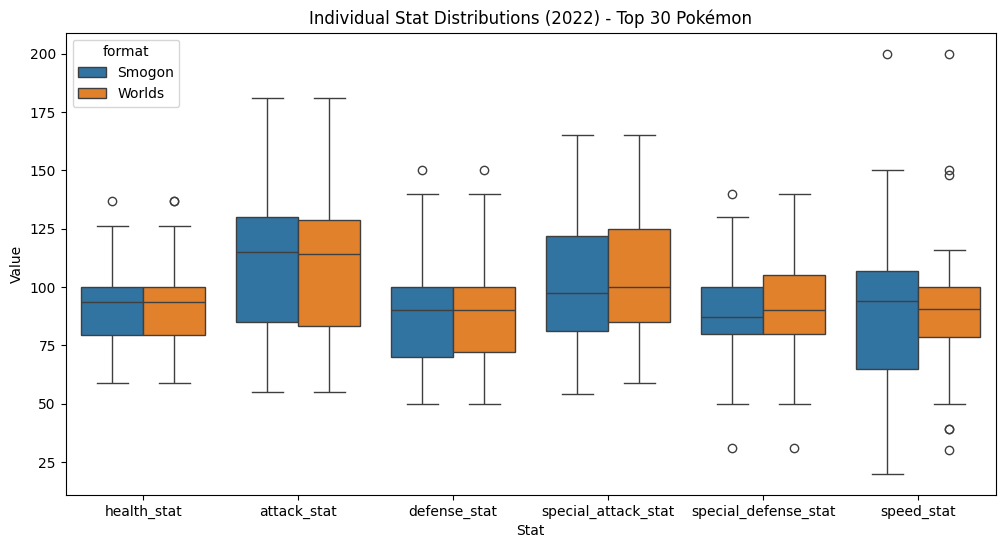

In [37]:
stat_cols = ["health_stat", "attack_stat", "defense_stat", 
             "special_attack_stat", "special_defense_stat", "speed_stat"]

melted_stats = pd.concat([
    smogon_2022.assign(format="Smogon")[stat_cols + ["format"]],
    worlds_2022.assign(format="Worlds")[stat_cols + ["format"]]
]).melt(id_vars="format", var_name="Stat", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_stats, x="Stat", y="Value", hue="format")
plt.title("Individual Stat Distributions (2022) - Top 30 Pokémon")
plt.show()


## Single type frequency across both formats

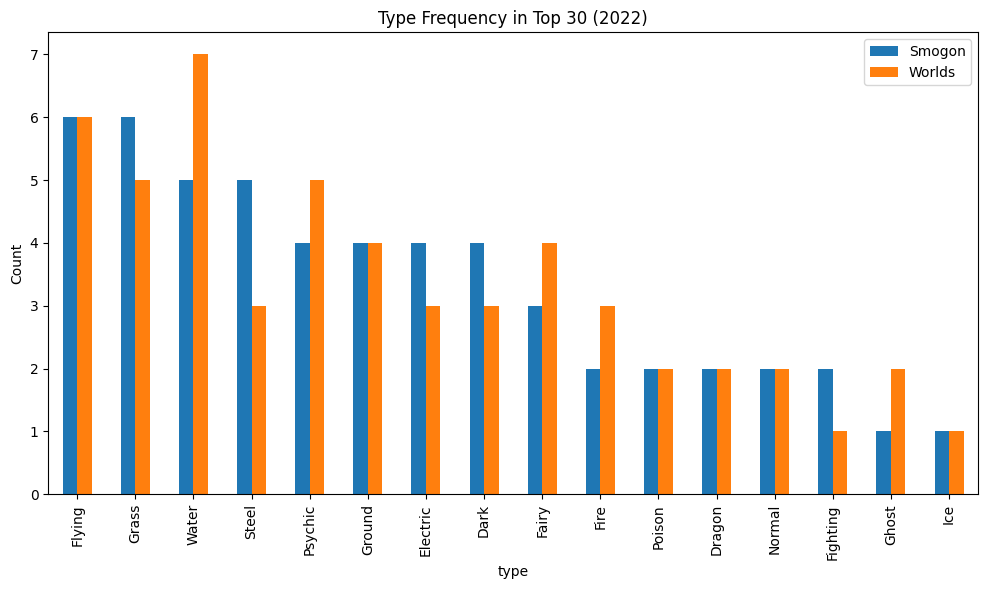

In [38]:
def get_type_counts(df):
    return Counter(df["primary_type"].tolist() + df["secondary_type"].dropna().tolist())

smogon_types = get_type_counts(smogon_2022)
worlds_types = get_type_counts(worlds_2022)

type_df = pd.DataFrame([
    {"type": t, "Smogon": smogon_types.get(t, 0), "Worlds": worlds_types.get(t, 0)}
    for t in set(smogon_types.keys()).union(worlds_types.keys())
])

type_df = type_df.sort_values(["Smogon", "Worlds"], ascending=False)

type_df.set_index("type")[["Smogon", "Worlds"]].plot(kind="bar", figsize=(12, 6))
plt.title("Type Frequency in Top 30 (2022)")
plt.ylabel("Count")
plt.show()

## Primary Ability frequency across both formats

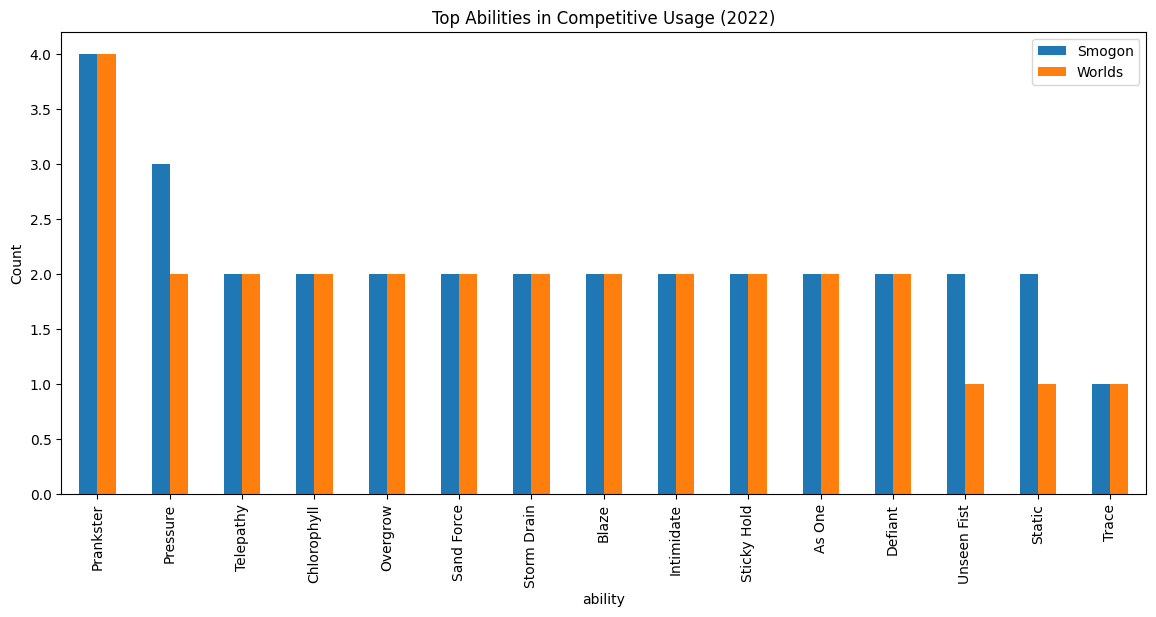

In [39]:
def ability_counts(df):
    all_abilities = df["primary_ability"].tolist() + \
                    df["secondary_ability"].dropna().tolist() + \
                    df["hidden_ability"].dropna().tolist()
    return Counter(all_abilities)

smogon_abilities = ability_counts(smogon_2022)
worlds_abilities = ability_counts(worlds_2022)

ability_df = pd.DataFrame([
    {"ability": a, "Smogon": smogon_abilities.get(a, 0), "Worlds": worlds_abilities.get(a, 0)}
    for a in set(smogon_abilities.keys()).union(worlds_abilities.keys())
])

top_abilities = ability_df.set_index("ability")[["Smogon", "Worlds"]].sort_values(by=["Smogon", "Worlds"], ascending=False).head(15)

top_abilities.plot(kind="bar", figsize=(14, 6))
plt.title("Top Abilities in Competitive Usage (2022)")
plt.ylabel("Count")
plt.show()

## All Ability frequency across both formats

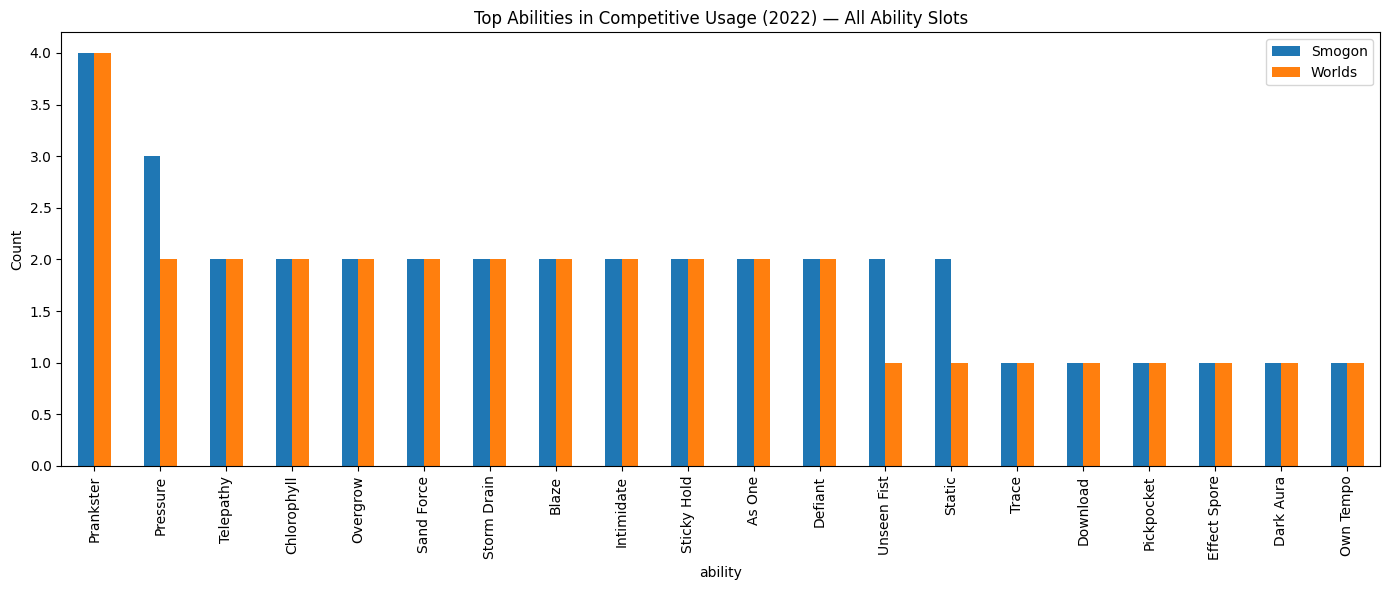

In [40]:
def ability_counts(df):
    all_abilities = (
        df["primary_ability"].dropna().tolist()
        + df["secondary_ability"].dropna().tolist()
        + df["hidden_ability"].dropna().tolist()
        + df["event_ability"].dropna().tolist()
    )
    return Counter(all_abilities)

# Count abilities for both formats
smogon_abilities = ability_counts(smogon_2022)
worlds_abilities = ability_counts(worlds_2022)

# Combine into one DataFrame
ability_df = pd.DataFrame([
    {"ability": a, "Smogon": smogon_abilities.get(a, 0), "Worlds": worlds_abilities.get(a, 0)}
    for a in set(smogon_abilities.keys()).union(worlds_abilities.keys())
])

# Show top 15 total-used abilities
top_abilities = ability_df.set_index("ability")[["Smogon", "Worlds"]].sort_values(
    by=["Smogon", "Worlds"], ascending=False
).head(20)

# Plot
top_abilities.plot(kind="bar", figsize=(14, 6))
plt.title("Top Abilities in Competitive Usage (2022) — All Ability Slots")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


> **Note:** Many Pokémon have multiple abilities (e.g., primary, secondary, hidden, or event). The chart above counts all listed abilities without knowing which one was used in practice. This may slightly inflate counts for Pokémon with multiple ability options.


## Single type distribution across both formats

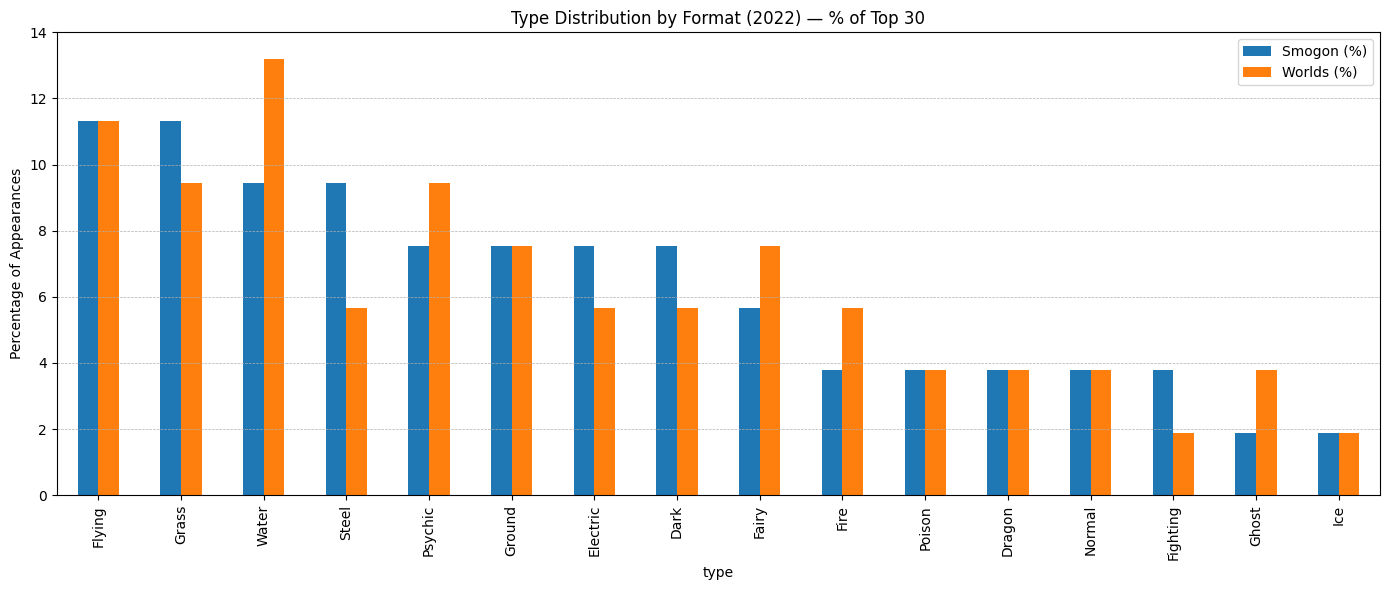

In [41]:
def type_frequency(df):
    types = df["primary_type"].tolist() + df["secondary_type"].dropna().tolist()
    return Counter(types)

# Raw counts
smogon_type_counts = type_frequency(smogon_2022)
worlds_type_counts = type_frequency(worlds_2022)

# Normalize to percentage
def normalize(counter):
    total = sum(counter.values())
    return {k: v / total * 100 for k, v in counter.items()}

smogon_type_pct = normalize(smogon_type_counts)
worlds_type_pct = normalize(worlds_type_counts)

# Combine into a DataFrame
type_df = pd.DataFrame([
    {"type": t, "Smogon (%)": smogon_type_pct.get(t, 0), "Worlds (%)": worlds_type_pct.get(t, 0)}
    for t in set(smogon_type_pct.keys()).union(worlds_type_pct.keys())
])

# Plotting
max_val = type_df[["Smogon (%)", "Worlds (%)"]].values.max()
ymax = np.ceil(max_val / 2) * 2 

type_df.set_index("type")[["Smogon (%)", "Worlds (%)"]].sort_values(
    by=["Smogon (%)", "Worlds (%)"], ascending=False
).plot(kind="bar", figsize=(14, 6))

plt.title("Type Distribution by Format (2022) — % of Top 30")
plt.ylabel("Percentage of Appearances")
plt.yticks(np.arange(0, ymax + 1, 2))  # ticks every 2%
plt.ylim(0, ymax)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Top 20 Ability distribution across both formats

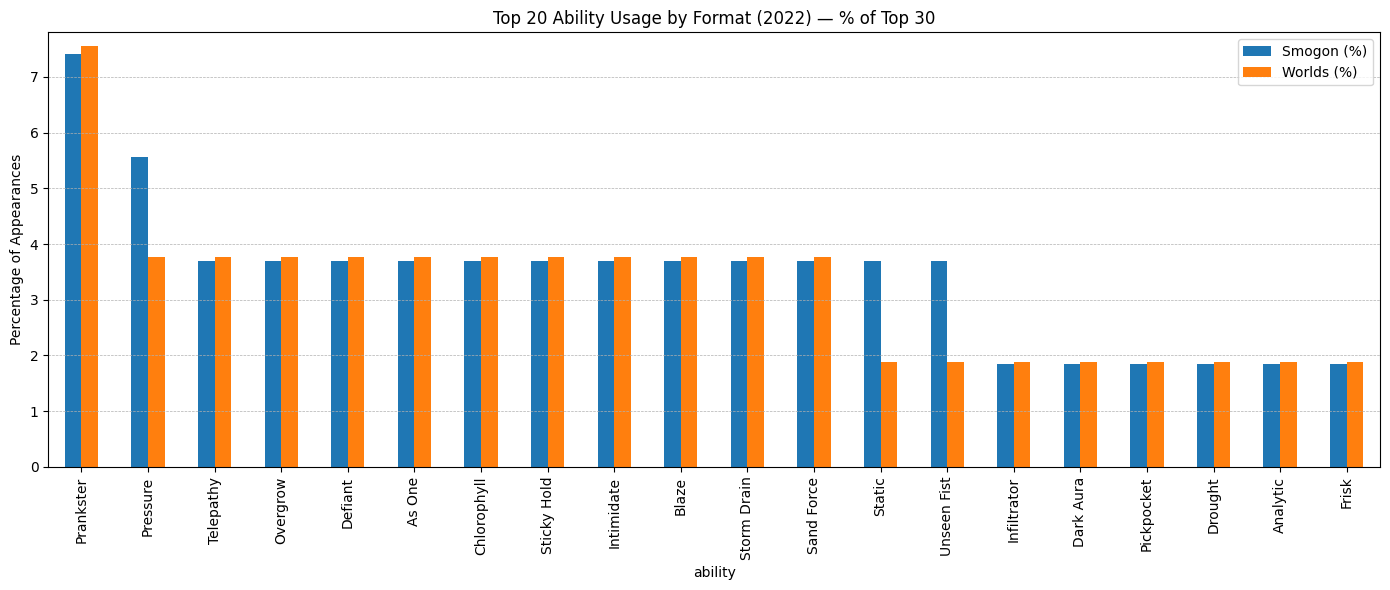

In [42]:
def ability_frequency(df):
    abilities = df["primary_ability"].tolist() + \
                df["secondary_ability"].dropna().tolist() + \
                df["hidden_ability"].dropna().tolist() + \
                df["event_ability"].dropna().tolist()
    return Counter(abilities)

# Raw counts
smogon_abilities = ability_frequency(smogon_2022)
worlds_abilities = ability_frequency(worlds_2022)

# Normalize
smogon_abilities_pct = normalize(smogon_abilities)
worlds_abilities_pct = normalize(worlds_abilities)

# Combine into a DataFrame
ability_df = pd.DataFrame([
    {"ability": a, "Smogon (%)": smogon_abilities_pct.get(a, 0), "Worlds (%)": worlds_abilities_pct.get(a, 0)}
    for a in set(smogon_abilities_pct.keys()).union(worlds_abilities_pct.keys())
])


# Get top 20 abilities by combined percentage
top_abilities_pct = ability_df.copy()
top_abilities_pct["Total"] = top_abilities_pct["Smogon (%)"] + top_abilities_pct["Worlds (%)"]
top_abilities_pct = top_abilities_pct.sort_values("Total", ascending=False).head(20)

# Determine precise y-axis range
max_val = top_abilities_pct[["Smogon (%)", "Worlds (%)"]].values.max()
ymax = np.ceil(max_val * 10) / 10 + 0.2  # round up to nearest 0.1


# Plot
top_abilities_pct.set_index("ability")[["Smogon (%)", "Worlds (%)"]].plot(
    kind="bar", figsize=(14, 6)
)

plt.title("Top 20 Ability Usage by Format (2022) — % of Top 30")
plt.ylabel("Percentage of Appearances")
plt.ylim(0, ymax)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



# Top 20 Type combinations across both formats

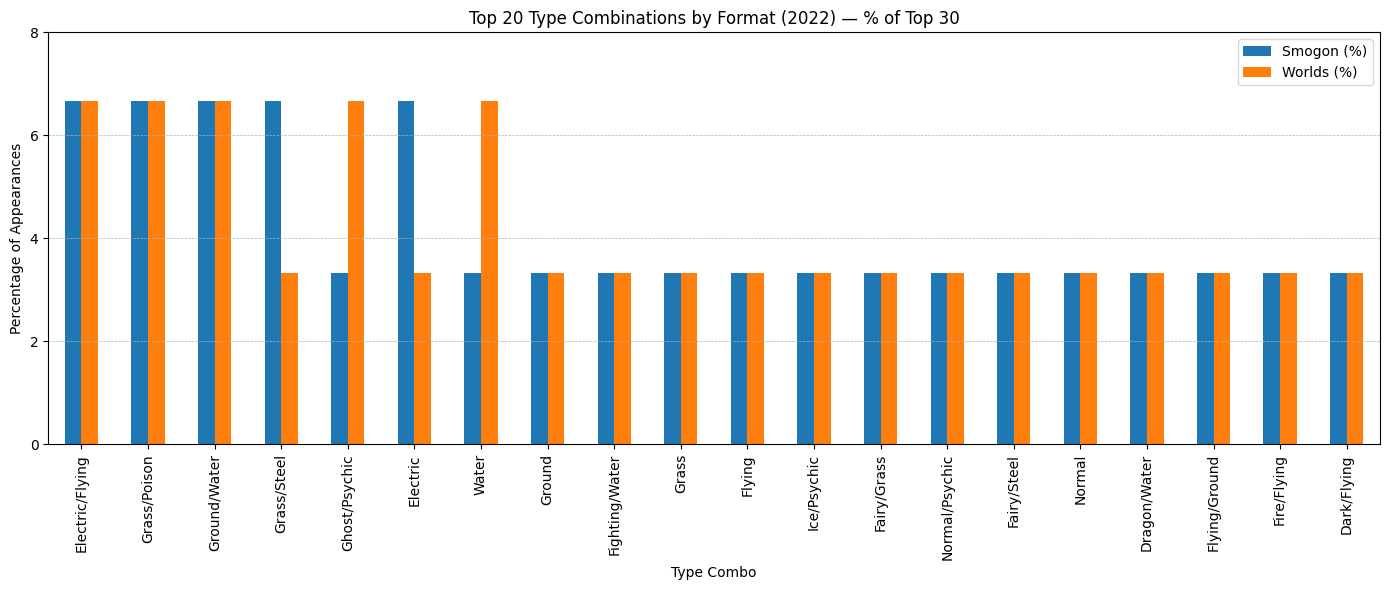

In [43]:
# === Helper to create type combos ===
def type_combos(df):
    combos = []
    for _, row in df.iterrows():
        types = [row["primary_type"]]
        if pd.notna(row["secondary_type"]):
            types.append(row["secondary_type"])
        combo = "/".join(sorted(types))  # sort to group e.g., "Fire/Flying" same as "Flying/Fire"
        combos.append(combo)
    return Counter(combos)

# Get counts
smogon_combos = type_combos(smogon_2022)
worlds_combos = type_combos(worlds_2022)

# Normalize to % usage
def normalize(counter):
    total = sum(counter.values())
    return {k: v / total * 100 for k, v in counter.items()}

smogon_pct = normalize(smogon_combos)
worlds_pct = normalize(worlds_combos)

# Combine into DataFrame
combo_df = pd.DataFrame([
    {"Type Combo": combo, "Smogon (%)": smogon_pct.get(combo, 0), "Worlds (%)": worlds_pct.get(combo, 0)}
    for combo in set(smogon_pct.keys()).union(worlds_pct.keys())
])

# Get top N combos by total usage
combo_df["Total"] = combo_df["Smogon (%)"] + combo_df["Worlds (%)"]
top_combos = combo_df.sort_values("Total", ascending=False).head(20).drop(columns="Total")

# Plot
max_val = top_combos[["Smogon (%)", "Worlds (%)"]].values.max()
ymax = np.ceil(max_val / 2) * 2

top_combos.set_index("Type Combo").plot(kind="bar", figsize=(14, 6))
plt.title("Top 20 Type Combinations by Format (2022) — % of Top 30")
plt.ylabel("Percentage of Appearances")
plt.yticks(np.arange(0, ymax + 1, 2))
plt.ylim(0, ymax)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


## Usage Score vs Base Stats

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/2601213380.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/rohanhangal/PersonalProjects/data_engineering/pokemon_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


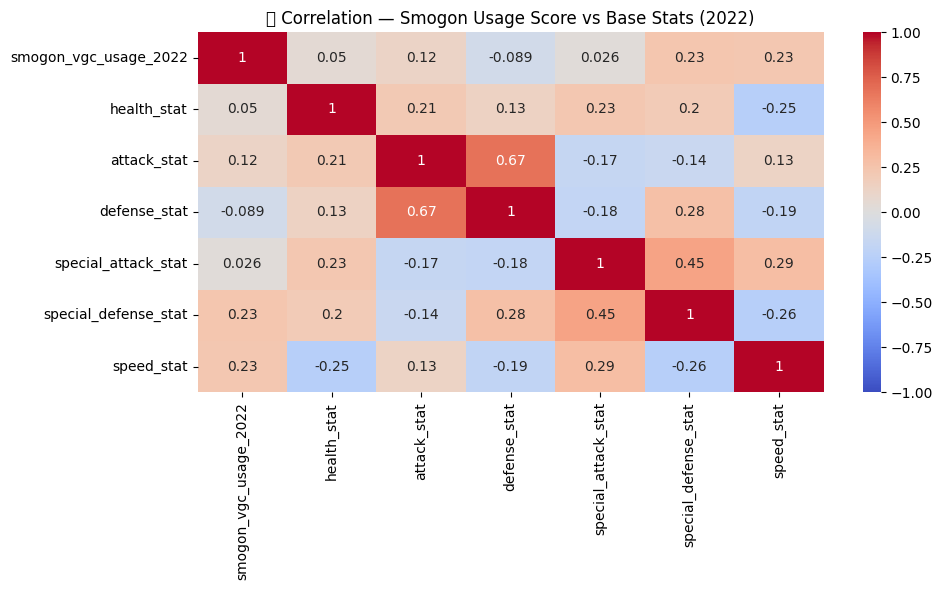

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_87776/2601213380.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/rohanhangal/PersonalProjects/data_engineering/pokemon_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


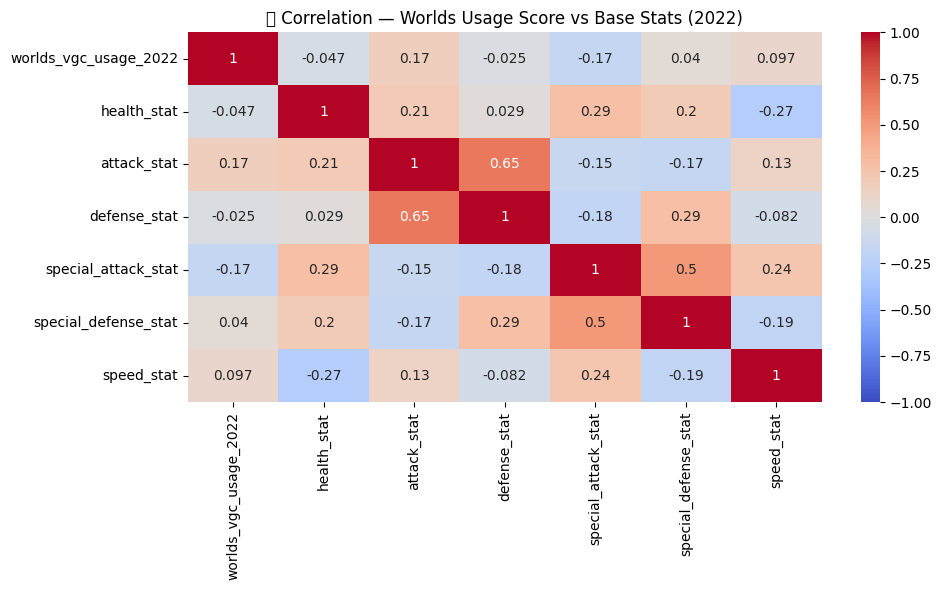

In [44]:
def plot_usage_correlation_heatmap(df, usage_col, title):
    stats_cols = [
        usage_col,
        "health_stat", "attack_stat", "defense_stat",
        "special_attack_stat", "special_defense_stat", "speed_stat"
    ]
    corr = df[stats_cols].corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"📈 Correlation — {title}")
    plt.tight_layout()
    plt.show()

plot_usage_correlation_heatmap(smogon_2022, "smogon_vgc_usage_2022", "Smogon Usage Score vs Base Stats (2022)")
plot_usage_correlation_heatmap(worlds_2022, "worlds_vgc_usage_2022", "Worlds Usage Score vs Base Stats (2022)")

## Smogon Outliers

In [45]:
# Get relevant stats
df = smogon_2022.copy()
df["z_stat_total"] = (df["base_stat_total"] - df["base_stat_total"].mean()) / df["base_stat_total"].std()

# Define thresholds (e.g., ±1.5 std dev)
outliers_high_stats = df[df["z_stat_total"] > 1.5]
outliers_low_stats = df[df["z_stat_total"] < -1.5]

# Low usage but high stats (underutilized tanks, maybe?)
underused_high_stats = df[(df["z_stat_total"] > 1) & (df["smogon_vgc_usage_2022"] < 5)]

# High usage, low stats (meta favorites with bad stats)
overused_low_stats = df[(df["z_stat_total"] < -0.5) & (df["smogon_vgc_usage_2022"] > 8)]

# 🔍 Show outliers
print("⚡ Outliers: High Stats")
display(outliers_high_stats[["pokemon_name", "base_stat_total", "smogon_vgc_usage_2022"]])

print("\n🛡️ Underused High-Stat Pokémon")
display(underused_high_stats[["pokemon_name", "base_stat_total", "smogon_vgc_usage_2022"]])

print("\n🔥 Overused Low-Stat Pokémon")
display(overused_low_stats[["pokemon_name", "base_stat_total", "smogon_vgc_usage_2022"]])


⚡ Outliers: High Stats


,pokemon_name,base_stat_total,smogon_vgc_usage_2022
0,Zacian,700,60.39172



🛡️ Underused High-Stat Pokémon


,pokemon_name,base_stat_total,smogon_vgc_usage_2022
29,Dialga,680,4.95032



🔥 Overused Low-Stat Pokémon


,pokemon_name,base_stat_total,smogon_vgc_usage_2022
1,Incineroar,530,58.57608
4,Grimmsnarl,510,26.28657
6,Venusaur,525,20.83915
7,Rillaboom,530,19.39555
9,Amoonguss,464,17.61546
16,Whimsicott,480,11.25129
17,Gastrodon,475,9.82964
18,Indeedee,475,8.37202


## Worlds Outliers

In [46]:
# Copy and compute Z-score on base stat total
worlds_df = worlds_2022.copy()
worlds_df["z_stat_total"] = (worlds_df["base_stat_total"] - worlds_df["base_stat_total"].mean()) / worlds_df["base_stat_total"].std()

# Define outlier groups
outliers_high_stats = worlds_df[worlds_df["z_stat_total"] > 1.5]
outliers_low_stats = worlds_df[worlds_df["z_stat_total"] < -1.5]

# High stat but low usage (underused)
underused_high_stats = worlds_df[(worlds_df["z_stat_total"] > 1) & (worlds_df["worlds_vgc_usage_2022"] < 5)]

# Low stat but high usage (overperformers)
overused_low_stats = worlds_df[(worlds_df["z_stat_total"] < -0.5) & (worlds_df["worlds_vgc_usage_2022"] > 8)]

# Print out groups
print("⚡ Outliers: High Stats")
display(outliers_high_stats[["pokemon_name", "base_stat_total", "worlds_vgc_usage_2022"]])

print("\n🛡️ Underused High-Stat Pokémon")
display(underused_high_stats[["pokemon_name", "base_stat_total", "worlds_vgc_usage_2022"]])

print("\n🔥 Overused Low-Stat Pokémon")
display(overused_low_stats[["pokemon_name", "base_stat_total", "worlds_vgc_usage_2022"]])


⚡ Outliers: High Stats


,pokemon_name,base_stat_total,worlds_vgc_usage_2022



🛡️ Underused High-Stat Pokémon


,pokemon_name,base_stat_total,worlds_vgc_usage_2022
27,Solgaleo,680,4.36
28,Reshiram,680,3.53



🔥 Overused Low-Stat Pokémon


,pokemon_name,base_stat_total,worlds_vgc_usage_2022
0,Incineroar,530,73.41
3,Grimmsnarl,510,30.40
4,Rillaboom,530,27.50
8,Charizard,534,20.53
9,Amoonguss,464,20.14
10,Venusaur,525,19.62
12,Whimsicott,480,15.89
15,Porygon2,515,13.21
17,Gastrodon,475,11.26
